# Create canonical labels attached to tessellation

This notebook combines results of the first and second level clustering, generating a canonical singature type ID reflecting both levels.

In [1]:
import pandas as pd
import geopandas as gpd
import dask.dataframe
import dask_geopandas

In [2]:
level1 = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/KMeans10GB.pq")

In [3]:
level1

kmeans10gb
hindex                      
c000e094707t0000           4
c000e094763t0000           0
c000e094763t0001           0
c000e094763t0002           0
c000e094764t0000           0
...                      ...
c102e644989t0111           0
c102e644989t0112           0
c102e644989t0113           0
c102e644989t0114           0
c102e644989t0115           0

[14539578 rows x 1 columns]

In [4]:
level2_9 = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/clustergram_cl9_labels.pq", columns=['9'])

In [5]:
level2_9

9
0       0
1       0
2       0
3       0
4       0
...    ..
113639  0
113640  0
113641  0
113642  0
113643  0

[113644 rows x 1 columns]

In [6]:
level2_2 = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/subclustering_cluster2_k3.pq")

In [7]:
level2_2

subclustering_cluster2_k3
hindex                                     
c000e097919t0003                          1
c000e097919t0005                          1
c000e097919t0008                          1
c000e097919t0009                          1
c000e097919t0015                          1
...                                     ...
c102e639766t0007                          0
c102e639766t0010                          0
c102e639766t0011                          0
c102e639766t0012                          0
c102e639766t0013                          0

[1115564 rows x 1 columns]

In [8]:
labels = level1.copy()
labels["signature_type"] = labels["kmeans10gb"]
labels.loc[labels.kmeans10gb == 9, "signature_type"] = (labels.loc[labels.kmeans10gb == 9, "signature_type"] * 10) + level2_9["9"].values
labels.loc[labels.kmeans10gb == 2, "signature_type"] = (labels.loc[labels.kmeans10gb == 2, "signature_type"] * 10) +level2_2["subclustering_cluster2_k3"].values

In [9]:
labels = labels.drop(columns=["kmeans10gb"])
labels

signature_type
hindex                          
c000e094707t0000               4
c000e094763t0000               0
c000e094763t0001               0
c000e094763t0002               0
c000e094764t0000               0
...                          ...
c102e644989t0111               0
c102e644989t0112               0
c102e644989t0113               0
c102e644989t0114               0
c102e644989t0115               0

[14539578 rows x 1 columns]

In [19]:
labels.to_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_labels.pq")

In [10]:
cells = dask_geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/")

In [11]:
cells = cells.merge(labels, how="left", left_on="hindex", right_index=True)

In [12]:
cells = cells.drop(columns="buildings")
cells = cells.rename(columns={"tessellation": "geometry"})
cells

Dask DataFrame Structure:
                 hindex geometry signature_type
npartitions=103                                
                 object   object        float64
                    ...      ...            ...
...                 ...      ...            ...
                    ...      ...            ...
                    ...      ...            ...
Dask Name: rename, 413 tasks

In [13]:
cells = dask_geopandas.from_dask_dataframe(cells)

In [14]:
cells

<dask_geopandas.GeoDataFrame | 516 tasks | 103 npartitions>

In [15]:
%%time
cells.to_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_tessellation/")

/opt/conda/lib/python3.8/site-packages/dask/utils.py:35: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  return func(*args, **kwargs)


CPU times: user 17min 44s, sys: 2min 26s, total: 20min 11s
Wall time: 20min 11s


We can check the result and its spatial partitioning.

In [16]:
cells = dask_geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_tessellation/")

In [17]:
cells

<dask_geopandas.GeoDataFrame | 103 tasks | 103 npartitions>

In [18]:
%%time
cells.calculate_spatial_partitions()

CPU times: user 27min 22s, sys: 34 s, total: 27min 57s
Wall time: 3min 22s


In [19]:
cells.spatial_partitions

0      POLYGON Z ((339010.000 426700.000 0.000, 33596...
1      POLYGON Z ((459529.390 339487.330 0.000, 45951...
2      POLYGON Z ((380696.000 228900.000 0.000, 37766...
3      POLYGON Z ((363161.000 541631.000 0.000, 33680...
4      POLYGON Z ((431181.406 393369.256 0.000, 40940...
                             ...                        
98     POLYGON Z ((448173.875 209362.352 0.000, 44814...
99     POLYGON Z ((513455.520 192183.030 0.000, 50044...
100    POLYGON Z ((172420.000 603651.000 0.000, 16125...
101    POLYGON Z ((419376.825 272261.845 0.000, 41514...
102    POLYGON Z ((367870.000 68210.000 0.000, 367820...
Length: 103, dtype: geometry

<AxesSubplot:>

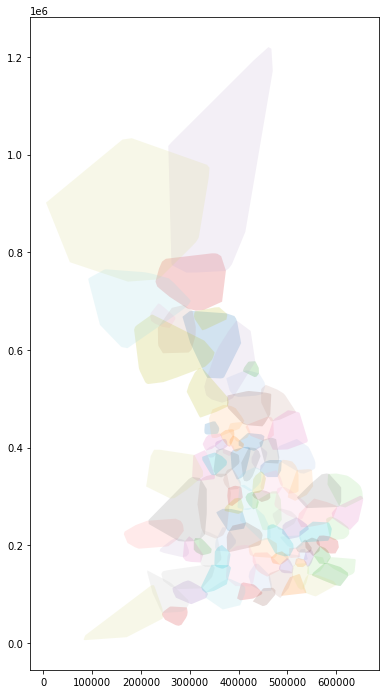

In [20]:
cells.spatial_partitions.plot(figsize=(12, 12), cmap="tab20", alpha=.2)